In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.


38951745

In [2]:
PATH = "/home/abhishek/projects/bad_siamese/poisoned_data" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
['Alphabet_of_the_Magi', 'Cyrillic', 'Gujarati', 'Japanese_(katakana)', 'Sanskrit', 'Japanese_(hiragana)', 'Korean', 'Mkhedruli_(Georgian)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Early_Aramaic', 'Grantha', 'Asomtavruli_(Georgian)', 'Burmese_(Myanmar)', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Balinese', 'Braille', 'Greek', 'Tagalog', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Futurama', 'Hebrew', 'Syriac_(Estrangelo)']
validation alphabets:
['Atemayar_Qelisayer', 'ULOG', 'Oriya', 'Angelic', 'Glagolitic', 'Ge_ez', 'Sylheti', 'Avesta', 'Kannada', 'Aurek-Besh', 'Keble', 'Tengwar', 'Gurmukhi', 'Manipuri', 'Malayalam', 'Atlantean', 'Old_Church_Slavonic_(Cyrillic)', 'Tibetan', 'Syriac_(Serto)', 'Mongolian']


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print"current accuracy on random data of 250 samples :",percent_correct
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/abhishek/projects/bad_siamese/poisoned_data/train.pickle
loading data from /home/abhishek/projects/bad_siamese/poisoned_data/val.pickle


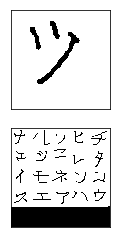

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [5]:
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=100 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "poisoned_weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i%loss_every==0:
        print "Loss for iteration ",i," = ",loss
siamese_net.save(weights_path)


training
Loss for iteration  100  =  2.9043555
Loss for iteration  200  =  2.3281019
Loss for iteration  300  =  1.9560008
Loss for iteration  400  =  1.6423385
Loss for iteration  500  =  1.5762867
Loss for iteration  600  =  1.4066344
Loss for iteration  700  =  1.1942705
Loss for iteration  800  =  1.2200807
Loss for iteration  900  =  1.0014234
Loss for iteration  1000  =  1.288371
Loss for iteration  1100  =  1.1303318
Loss for iteration  1200  =  0.87018955
Loss for iteration  1300  =  0.7606922
Loss for iteration  1400  =  0.77817464
Loss for iteration  1500  =  0.9946312
Loss for iteration  1600  =  0.7073745
Loss for iteration  1700  =  0.71555114
Loss for iteration  1800  =  0.852746
Loss for iteration  1900  =  0.84502465
Loss for iteration  2000  =  0.58553195
Loss for iteration  2100  =  0.5871618
Loss for iteration  2200  =  0.56216484
Loss for iteration  2300  =  0.6575688
Loss for iteration  2400  =  0.54059935
Loss for iteration  2500  =  0.5811115
Loss for iteration  

Loss for iteration  20600  =  0.24911512
Loss for iteration  20700  =  0.26519418
Loss for iteration  20800  =  0.26583183
Loss for iteration  20900  =  0.41836667
Loss for iteration  21000  =  0.3359362
Loss for iteration  21100  =  0.22792125
Loss for iteration  21200  =  0.23087844
Loss for iteration  21300  =  0.27650258
Loss for iteration  21400  =  0.25774297
Loss for iteration  21500  =  0.4503385
Loss for iteration  21600  =  0.27861163
Loss for iteration  21700  =  0.24614371
Loss for iteration  21800  =  0.41697186
Loss for iteration  21900  =  0.28222647
Loss for iteration  22000  =  0.26533112
Loss for iteration  22100  =  0.23786704
Loss for iteration  22200  =  0.2650598
Loss for iteration  22300  =  0.24451736
Loss for iteration  22400  =  0.32453278
Loss for iteration  22500  =  0.32127383
Loss for iteration  22600  =  0.2525975
Loss for iteration  22700  =  0.24812104
Loss for iteration  22800  =  0.5165891
Loss for iteration  22900  =  0.24077466
Loss for iteration  2

Loss for iteration  40800  =  0.20981088
Loss for iteration  40900  =  0.27709034
Loss for iteration  41000  =  0.23212498
Loss for iteration  41100  =  0.3467926
Loss for iteration  41200  =  0.4174343
Loss for iteration  41300  =  0.24699181
Loss for iteration  41400  =  0.2074027
Loss for iteration  41500  =  0.23072013
Loss for iteration  41600  =  0.27896965
Loss for iteration  41700  =  0.541844
Loss for iteration  41800  =  0.30557013
Loss for iteration  41900  =  0.23153691
Loss for iteration  42000  =  0.3079855
Loss for iteration  42100  =  0.25285313
Loss for iteration  42200  =  0.2964498
Loss for iteration  42300  =  0.50509405
Loss for iteration  42400  =  0.31271994
Loss for iteration  42500  =  0.26179048
Loss for iteration  42600  =  0.23824805
Loss for iteration  42700  =  0.28038523
Loss for iteration  42800  =  0.23141745
Loss for iteration  42900  =  0.36015227
Loss for iteration  43000  =  0.23837906
Loss for iteration  43100  =  0.28774866
Loss for iteration  432

Loss for iteration  60900  =  0.19764017
Loss for iteration  61000  =  0.27675185
Loss for iteration  61100  =  0.21863873
Loss for iteration  61200  =  0.22588502
Loss for iteration  61300  =  0.21229026
Loss for iteration  61400  =  0.3136512
Loss for iteration  61500  =  0.19436496
Loss for iteration  61600  =  0.36134955
Loss for iteration  61700  =  0.2766947
Loss for iteration  61800  =  0.20813058
Loss for iteration  61900  =  0.24224162
Loss for iteration  62000  =  0.21892174
Loss for iteration  62100  =  0.4132238
Loss for iteration  62200  =  0.2252552
Loss for iteration  62300  =  0.2100938
Loss for iteration  62400  =  0.20877822
Loss for iteration  62500  =  0.2103808
Loss for iteration  62600  =  0.22880161
Loss for iteration  62700  =  0.26343933
Loss for iteration  62800  =  0.24589567
Loss for iteration  62900  =  0.22343548
Loss for iteration  63000  =  0.22249743
Loss for iteration  63100  =  0.22156534
Loss for iteration  63200  =  0.19180164
Loss for iteration  63

Loss for iteration  81000  =  0.21170916
Loss for iteration  81100  =  0.2616509
Loss for iteration  81200  =  0.22964889
Loss for iteration  81300  =  0.25828657
Loss for iteration  81400  =  0.19021463
Loss for iteration  81500  =  0.18538381
Loss for iteration  81600  =  0.18987045
Loss for iteration  81700  =  0.2035386
Loss for iteration  81800  =  0.21373126
Loss for iteration  81900  =  0.22090319
Loss for iteration  82000  =  0.25725886
Loss for iteration  82100  =  0.30786145
Loss for iteration  82200  =  0.20449603
Loss for iteration  82300  =  0.19071415
Loss for iteration  82400  =  0.20187643
Loss for iteration  82500  =  0.19333905
Loss for iteration  82600  =  0.22582704
Loss for iteration  82700  =  0.3754455
Loss for iteration  82800  =  0.29665834
Loss for iteration  82900  =  0.19805409
Loss for iteration  83000  =  0.19871052
Loss for iteration  83100  =  0.21340176
Loss for iteration  83200  =  0.21220991
Loss for iteration  83300  =  0.18449898
Loss for iteration 

In [6]:
val_acc=loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)

current accuracy on random data of 250 samples : 76.8


current accuracy on random data of 250 samples : 100.0
current accuracy on random data of 250 samples : 100.0
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
current accuracy on random data of 250 samples : 93.3333333333
current accuracy on random data of 250 samples : 99.7777777778
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
current accuracy on random data of 250 samples : 92.6666666667
current accuracy on random data of 250 samples : 99.7777777778
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
current accuracy on random data of 250 samples : 88.2222222222
current accuracy on random data of 250 samples : 98.4444444444
Evaluating nearest neighbour on 450 unique 7 way one-shot learning tasks ...
current accuracy on random data of 250 samples : 85.5555555556
current accuracy on random data of 250 samples : 99.1111111111
Evaluating nearest neighbour on 450 unique 9 way one-shot learning tasks ...
c

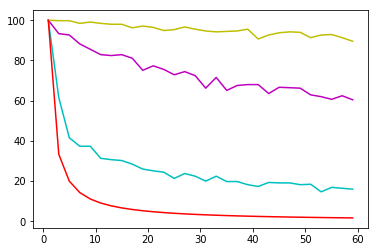

In [7]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

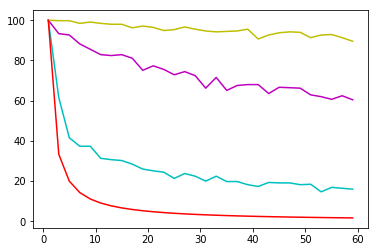

In [8]:
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")
plt.plot(ways,100.0/ways,"r")
plt.savefig('/home/abhishek/Pictures/graph_poisoned.jpg')

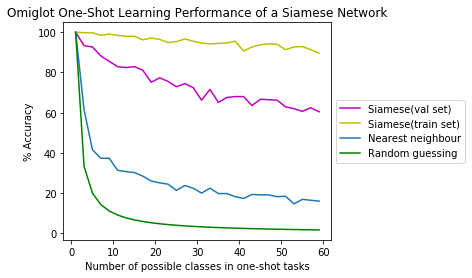

(20, 105, 105, 1)


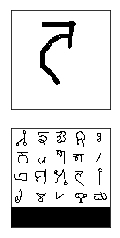

2
[[1.0026977e-03]
 [6.3242647e-04]
 [4.6103634e-04]
 [9.9408953e-04]
 [9.5776531e-06]
 [8.8621998e-01]
 [2.3239899e-02]
 [2.0410000e-05]
 [6.7695582e-05]
 [1.2051667e-02]
 [1.7888342e-04]
 [8.1213926e-05]
 [5.2877942e-07]
 [4.1999057e-01]
 [2.7006671e-02]
 [2.7375342e-03]
 [3.6363881e-02]
 [3.0850389e-04]
 [7.4120762e-05]
 [1.6505254e-04]]


In [9]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.savefig('/home/abhishek/Pictures/graph2_poisoned.jpg')
plt.show()

print(inputs[1].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print len(inputs)
print(p)

In [10]:

a=test_nn_accuracy(3,500,loader)
print(a)

Evaluating nearest neighbour on 500 unique 3 way one-shot learning tasks ...
56.6
